# **Siamese Networks**

In [19]:
import keras
from keras import layers, losses, optimizers, models, losses
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

### Loading and normalizing the MNIST dataset

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

### Preparing the data in pairs

In [11]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            dn = (d + 6) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [12]:
digit_ind = []
for i in range(10):
  digit_ind.append(np.argwhere(y_train == i).flatten())
train_pairs, train_y = create_pairs(x_train, digit_ind)

digit_ind = []
for i in range(10):
  digit_ind.append(np.argwhere(y_test == i).flatten())
test_pairs, test_y = create_pairs(x_test, digit_ind)

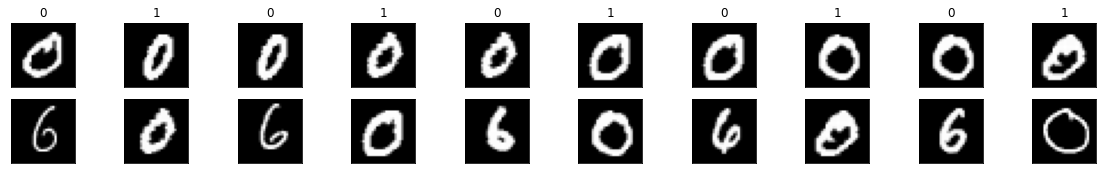

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(train_pairs[i+3][0].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(train_y[i+3])

    # encoded / compressed
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(train_pairs[i+3][1].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Building the Model

In [14]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [27]:
input = layers.Input(shape=(28,28))
x = layers.Flatten()(input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu')(x)

shared_model = models.Model(input, x)
shared_model.summary()

input_a = layers.Input(shape=(28,28))
input_b = layers.Input(shape=(28,28))

processed_a = shared_model(input_a)
processed_b = shared_model(input_b)

distance = layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

siamese_model = models.Model([input_a, input_b], distance)

siamese_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
Total params: 116,992
Trainable params: 116,992
Non-trainable params: 0
_________________________________________________________________
Model: "model_7"
__________________________________________________________________________________________________
Lay

In [26]:
def contrastive_loss(y_true, y_pred):
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(1 - y_pred, 0)))

siamese_model.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])

history = siamese_model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y, batch_size=128, epochs=15, validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y))

Epoch 1/15


TypeError: ignored

## **Pros and Cons of Siamese Networks**

### Advantages

- More Robust to class Imbalance: Given a few images per class is sufficient for Siamese Networks to recognize those images in the future

- Learning from Semantic Similarity: Siamese focuses on learning embeddings (in the deeper layer) that place the same classes/concepts close together. Hence, can learn semantic similarity.

### Disadvantages

- Needs more training time than normal networks.
- More hyperparameters involved, thus more tuning required.
- Computationally expensive.